In [1]:
%config Completer.use_jedi = False

In [2]:
from typing import Dict, Hashable, Any, Optional
import contextlib
import numpy as np
import xarray as xr

from xarray.core.variable import Variable

from xarray.backends.common import BACKEND_ENTRYPOINTS

import tiledb

import datashader as ds
from datashader.transfer_functions import shade, stack, Images
from datashader.colors import viridis, inferno

In [18]:
def td_to_str(td):
    return str(td.astype("timedelta64[ns]").astype(float))


TIMEDELTAS = {
    td_to_str(np.timedelta64(1, "D")): "D",
    td_to_str(np.timedelta64(1, "W")): "W",
    td_to_str(np.timedelta64(1, "M")): "M",
    td_to_str(np.timedelta64(1, "Y")): "Y",
    td_to_str(np.timedelta64(1, "h")): "h",
    td_to_str(np.timedelta64(1, "m")): "m",
    td_to_str(np.timedelta64(1, "s")): "s",
    td_to_str(np.timedelta64(1, "ms")): "ms",
    td_to_str(np.timedelta64(1, "us")): "us",
    td_to_str(np.timedelta64(1, "ns")): "ns",
    td_to_str(np.timedelta64(1, "ps")): "ps",
    td_to_str(np.timedelta64(1, "fs")): "fs",
    td_to_str(np.timedelta64(1, "as")): "as",
}


class XarrayToTileDBWriter:
    def __init__(self, dataset: xr.Dataset, path: str, ctx: tiledb.Ctx=None, key: str = None):
        self.default_dtype = np.int32
        self.dataset = dataset
        self.path = path
        self.ctx = ctx
        self.key = key

    def write_tdb_array(
        self, data: Dict[Optional[Hashable], Any], metadata: Dict[Hashable, Any] = None
    ):
        try:
            with tiledb.open(self.path, "w", ctx=self.ctx, key=self.key) as array:
                array[:] = data
                if metadata is not None:
                    for key, value in metadata.items():
                        array.meta[key] = value
            return True
        except tiledb.TileDBError as err:
            print(f"Error while trying to write TileDB Array: {err}\n\n\n")
            return False

    def to_tiledb(self):  # noqa: C901
        #  set default int/uint dtype if in dims,
        #  overwrites itself with last 'iu' dim dtype
        dataset = self.dataset
        path = self.path

        dtypes = []
        for dim in dataset.dims.keys():
            dt = dataset[dim].dtype
            dtypes.append(dt)
        for dt in dtypes:
            if dt.kind in "iu":
                self.default_dtype = dt

        coords = dataset.coords
        w_dims = ("x", "w", "width", "lon", "lng", "long", "longitude")
        h_dims = ("y", "h", "height", "lat", "latitude")
        band_dims = ("band", "bands", "count")

        tdb_dims = []
        for name in coords:
            if name in dataset.dims:
                coord = coords[name]

                min_value = coord.data[0]
                max_value = coord.data[-1]
                dtype = coord.dtype

                is_spatial_ds = False
                if dataset.attrs and "transform" in dataset.attrs:
                    is_spatial_ds = True
                if is_spatial_ds and str(name).lower() in (*w_dims, *h_dims, *band_dims):
                    min_value = 1
                    max_value = len(coord.data)
                    dtype = self.default_dtype

                if dtype.kind not in "iuM":
                    raise NotImplementedError(
                        f"TDB Arrays don't work yet with this dtype coord {dtype}"
                    )

                if dtype.kind == "M":
                    second_value = coord.data[1]
                    step = second_value - min_value
                    freq_key = str(step.astype("timedelta64[ns]").astype(float))
                    assert freq_key in TIMEDELTAS
                    freq = TIMEDELTAS[freq_key]
                    date_range = pd.date_range(min_value, max_value, freq=freq)
                    assert (coord.data == date_range).all()

                    if not dataset.attrs:
                        dataset.attrs = dict()
                    if name not in dataset.attrs:
                        dataset.attrs[name] = dict()
                    dataset.attrs[name]["time"] = dict(
                        reference=str(min_value), freq=freq
                    )

                    min_value = 1
                    max_value = len(coord.data)
                    dtype = self.default_dtype

                # test for NetCDF dimension type coord starting at 0
                if min_value == 0:
                    min_value, max_value = min_value + 1, max_value + 1

                domain = (min_value, max_value)
                tdb_dim = tiledb.Dim(name=name, domain=domain, dtype=dtype, ctx=self.ctx)
                tdb_dims.append(tdb_dim)

        dom = tiledb.Domain(*tdb_dims, ctx=self.ctx)

        data_vars = []
        data = dict()
        for var in dataset.data_vars:
            var = dataset[var]
            data_var = tiledb.Attr(name=var.name, dtype=var.dtype, ctx=self.ctx)
            data_vars.append(data_var)
            data[var.name] = var.data

        schema = tiledb.ArraySchema(domain=dom, attrs=data_vars, sparse=False, ctx=self.ctx)

        if tiledb.array_exists(path):
            tiledb.remove(path, ctx=self.ctx)
        
        try:
            tiledb.DenseArray.create(path, schema, ctx=self.ctx, key=self.key)
        except tiledb.TileDBError as err:
            print(f"Error while trying to create TileDB Array {err}")
            return False

        metadata = dict()

        data_var_attrs = dict()
        dim_attrs = dict()
        for key, value in dataset.attrs.items():
            if type(value) in (tuple, list):
                value = " ".join([str(val) for val in value])
            elif "dtype" in value.__dir__():
                if value.dtype.kind in "iu":
                    value = int(value)
                elif value.dtype.kind == "f":
                    value = float(value)
                elif value.dtype.kind == "M":
                    value = str(value)
            if key not in dataset.data_vars and key not in dataset.dims:
                metadata[key] = value
            elif key in dataset.data_vars:
                data_var_attrs[key] = value
            elif key in dataset.dims:
                dim_attrs[key] = value

        for var_name, attrs in data_var_attrs.items():
            key_prefix = f"{_ATTR_PREFIX}{var_name}"
            if isinstance(attrs, dict):
                for attr_name, value in attrs.items():
                    key = f"{key_prefix}.{attr_name}"
                    if isinstance(value, np.datetime64):
                        value = str(value)
                    metadata[key] = value
            else:
                metadata[key_prefix] = attrs

        for dim_name, attrs in dim_attrs.items():
            key_prefix = f"{_DIM_PREFIX}{dim_name}"
            if isinstance(attrs, dict):
                for attr_name, value in attrs.items():
                    key = f"{key_prefix}.{attr_name}"
                    if isinstance(value, dict):
                        for sub_attr, sub_value in value.items():
                            sub_key = f"{key}.{sub_attr}"
                            metadata[sub_key] = sub_value
                    else:
                        if isinstance(value, np.datetime64):
                            value = str(value)
                        metadata[key] = value
            else:
                metadata[key_prefix] = attrs

        return self.write_tdb_array(data, metadata)


In [19]:
gis_data_arr = xr.open_rasterio("./resources/UTM2GTIF.tiff")
gis_data_arr.name = "gis_a"
gis_data_arr_b = gis_data_arr.copy() + 100
gis_data_arr_b.name = "gis_b"
gis_dataset = xr.merge((gis_data_arr, gis_data_arr_b))
gis_dataset

<xarray.Dataset>
Dimensions:  (band: 1, y: 929, x: 699)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.641e+06 4.64e+06 4.64e+06 ... 4.631e+06 4.631e+06
  * x        (x) float64 4.447e+05 4.447e+05 4.447e+05 ... 4.516e+05 4.516e+05
Data variables:
    gis_a    (band, y, x) uint8 ...
    gis_b    (band, y, x) uint8 106 106 106 106 106 106 ... 106 106 106 106 106
Attributes:
    transform:               (10.0, 0.0, 444650.0, 0.0, -10.0, 4640510.0)
    crs:                     +init=epsg:26716
    res:                     (10.0, 10.0)
    is_tiled:                0
    nodatavals:              (nan,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72


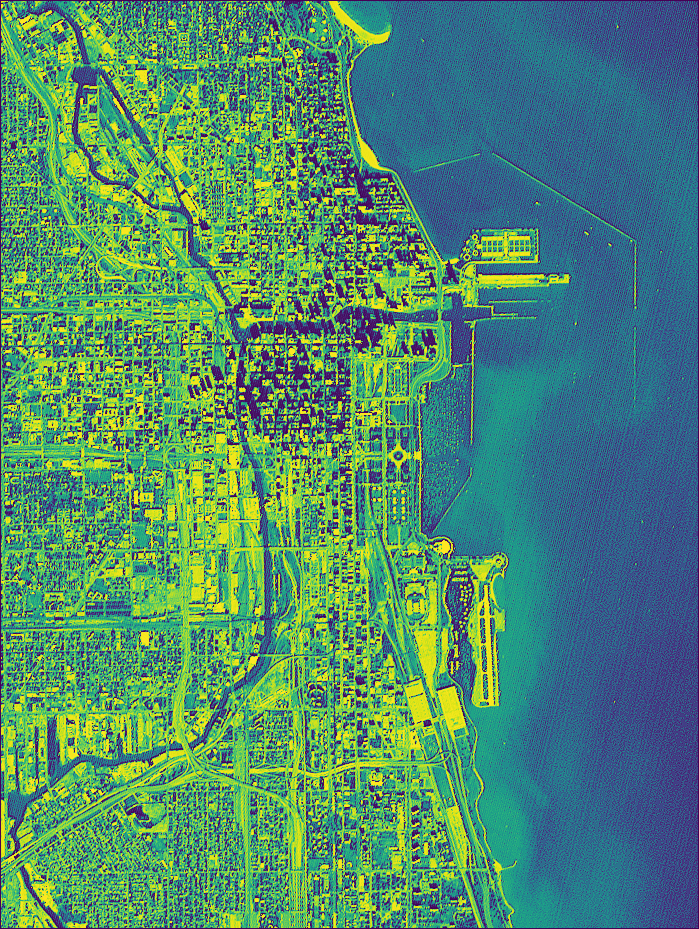
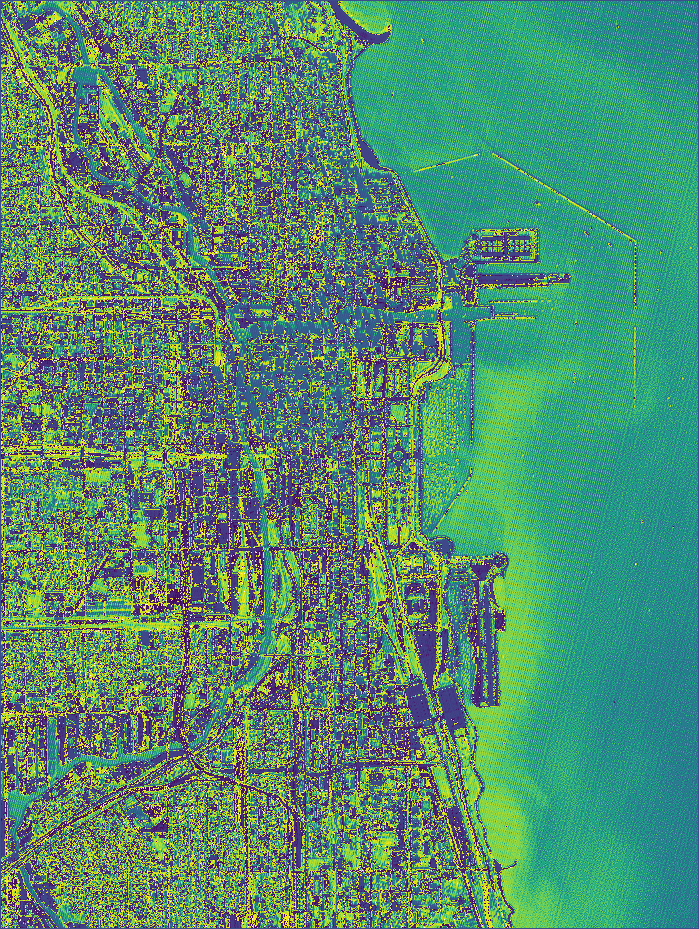

In [20]:
gis_a_data_arr = gis_dataset["gis_a"]
shade_a = shade(gis_a_data_arr[0], cmap=viridis)

gis_b_data_arr = gis_dataset["gis_b"]
shade_b = shade(gis_b_data_arr[0], cmap=viridis)

image_ab = Images(shade_a, shade_b)
image_ab

In [21]:
# username = "chloe.taub"
# password = ""

# config = tiledb.Config()
# config["rest.username"] = username
# config["rest.password"] = password

# ctx = tiledb.Ctx(config)
# key = ""

In [25]:
# s3_folder = "tiledb-chloe-samples"
# array_name = "test_dataset_chicago_c"
# tdb_path = f"tiledb://{username}/s3://{s3_folder}/{array_name}"
local_tdb_path = "../../../../Documents/tdb/gis_dataset_a"
writer = XarrayToTileDBWriter(dataset=gis_dataset, path=tdb_path)
writer.to_tiledb()

True

In [26]:
reopened_ds = xr.open_dataset(tdb_path, engine="tiledb")
reopened_ds

<xarray.Dataset>
Dimensions:  (band: 1, y: 929, x: 699)
Coordinates:
  * band     (band) int64 1
  * y        (y) int64 1 2 3 4 5 6 7 8 9 ... 921 922 923 924 925 926 927 928 929
  * x        (x) int64 1 2 3 4 5 6 7 8 9 ... 691 692 693 694 695 696 697 698 699
Data variables:
    gis_a    (band, y, x) float32 ...
    gis_b    (band, y, x) float32 ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    crs:                     +init=epsg:26716
    is_tiled:                0
    nodatavals:              nan
    offsets:                 0.0
    res:                     10.0 10.0
    scales:                  1.0
    transform:               10.0 0.0 444650.0 0.0 -10.0 4640510.0


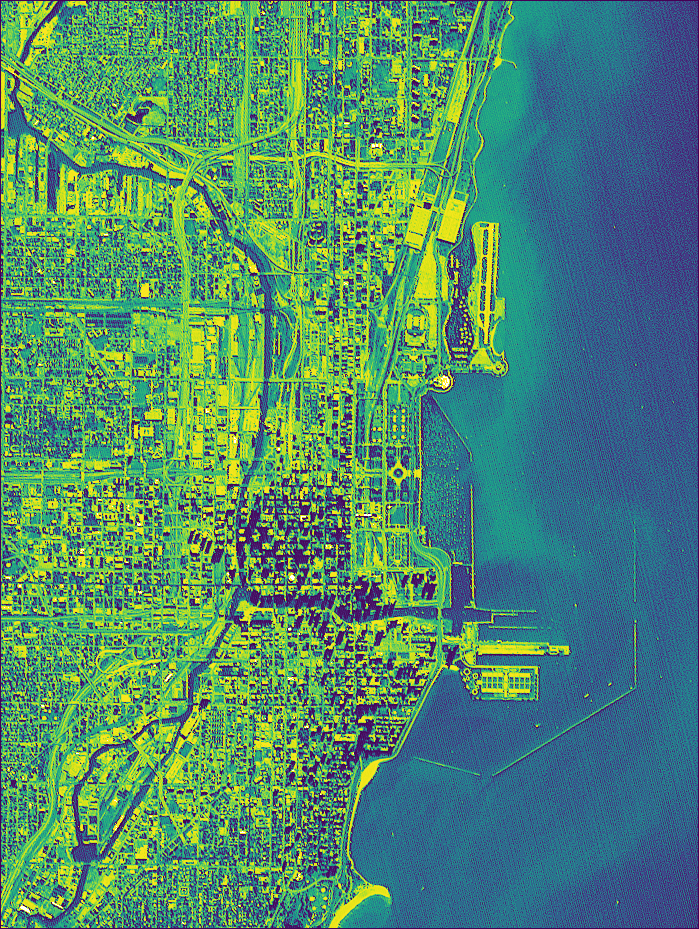
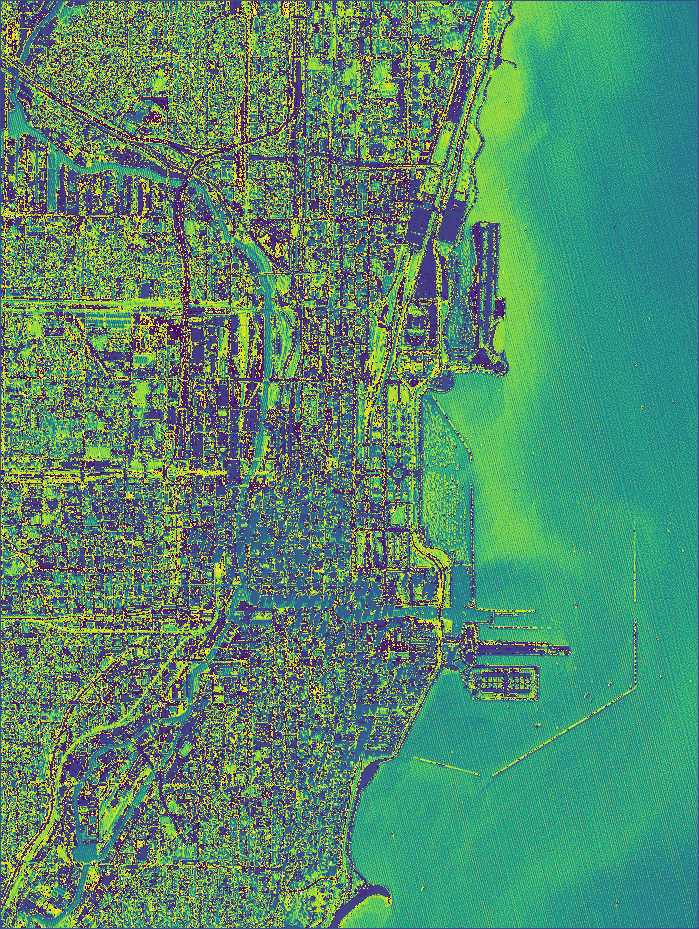

In [27]:
gis_a_da = reopened_ds["gis_a"]
shade_a_reopened = shade(gis_a_da[0], cmap=viridis)

gis_b_da = reopened_ds["gis_b"]
shade_b_reopened = shade(gis_b_da[0], cmap=viridis)

image_ab_reopened = Images(shade_a_reopened, shade_b_reopened)
image_ab_reopened